In [1]:
!nvidia-smi

Wed Sep 27 10:06:38 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.26                 Driver Version: 375.26                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:02:00.0     Off |                  N/A |
|  0%   34C    P8    14W / 200W |   7929MiB /  8113MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:03:00.0     Off |                  N/A |
|  0%   34C    P8    15W / 200W |      0MiB /  8112MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [12]:
import numpy as np
a = np.array([[1,2,3]])
print(a.shape)
np.tile(a, 3).reshape((*a.shape, 3)).shape

(1, 3)


(1, 3, 3)

In [2]:
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
import tensorflow as tf
import numpy as np
import sys
import os

sys.path.append(os.path.join("..", "..", ".."))
import ecg.dataset as ds
from ecg.batch import ModelEcgBatch

%env CUDA_VISIBLE_DEVICES=1
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.33
config.gpu_options.allow_growth=True

Using TensorFlow backend.


env: CUDA_VISIBLE_DEVICES=1


## Train pipeline

In [3]:
triplet_train_pipeline = (ds.Pipeline()
                          .load(fmt="wfdb", components=["signal", "meta"])
                          .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv",
                                fmt="csv", components="target")
                          .drop_labels(["~"])
                          .drop_short_signals(6000)
                          .get_triplets(100, 3000)
                          .signal_transpose([0, 2, 1])
                          .train_on_batch('triplet_learn')
                          .run(batch_size=300, shuffle=True, drop_last=True,
                               n_epochs=10, prefetch=0, lazy=True))

In [4]:
index = ds.FilesIndex(path="/notebooks/data/ECG/training2017/*.hea", no_ext=True, sort=True)
eds = ds.Dataset(index, batch_class=ModelEcgBatch)
eds.cv_split(0.8)
triplet_trained = (eds.train >> triplet_train_pipeline).run()

## Show loss on train

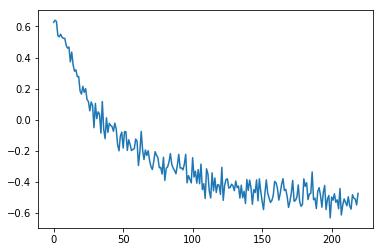

In [6]:
plt.plot(triplet_trained.get_model_by_name('triplet_learn').hist['train_loss'])
plt.show()

## Save pretrained model

In [7]:
(triplet_trained.get_model_by_name("triplet_learn")
                .save("/notebooks/e_illarionov/ecg_repo/model_dump/triplet_latest"))

## Test pipeline

In [9]:
triplet_test_pipeline = (ds.Pipeline()
                         .import_model('triplet_learn', triplet_trained)
                         .load(fmt="wfdb", components=["signal", "meta"])
                         .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv",
                               fmt="csv", components="target")
                         .drop_labels(["~"])
                         .drop_short_signals(6000)
                         .get_triplets(100, 3000)
                         .signal_transpose([0, 2, 1])
                         .test_on_batch('triplet_learn')
                         .run(batch_size=300, shuffle=True, drop_last=True, n_epochs=1, prefetch=0, lazy=True))

In [10]:
res_test = (eds.test >> triplet_test_pipeline).run()

## Show loss on test

In [11]:
print(np.mean(res_test.get_model_by_name('triplet_learn').hist['val_loss']))

-0.0149825


## Predict pipeline

In [12]:
config = {'path': "/notebooks/e_illarionov/ecg_repo/model_dump/triplet_latest"}

triplet_predict_pipeline = (ds.Pipeline(config={'triplet_pretrained': config})
                            .init_model('triplet_pretrained')
                            .init_variable("prediction", init=list)
                            .load(fmt="wfdb", components=["signal", "meta"])
                            .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv",
                                  fmt="csv", components="target")
                            .drop_labels(["~"])
                            .drop_short_signals(6000)
                            .get_triplets(100, 3000)
                            .signal_transpose([0, 2, 1])
                            .predict_on_batch('triplet_learn')
                            .run(batch_size=300, shuffle=False, drop_last=False, n_epochs=1, prefetch=0, lazy=True))

In [13]:
res_predict = (eds.test >> triplet_predict_pipeline).run()

In [14]:
res_predict.get_variable('prediction')

[array([[ 0.97557139,  0.94666904],
        [ 0.94861841,  0.95804429],
        [ 0.86903733,  0.89698279],
        [ 0.98532945,  0.86660266],
        [ 0.97898084,  0.92597955],
        [ 0.95732987,  0.93606192],
        [ 0.94973582,  0.90763319],
        [ 0.97912985,  0.92577827],
        [ 0.8968395 ,  0.93146372],
        [ 0.95630568,  0.93538558],
        [ 0.9537071 ,  0.98062897],
        [ 0.89451569,  0.87081552],
        [ 0.9102546 ,  0.93001014],
        [ 0.82119471,  0.80918723],
        [ 0.94194686,  0.81674838],
        [ 0.91049349,  0.93463647],
        [ 0.96525824,  0.97302949],
        [ 0.93500823,  0.91842252],
        [ 0.90328467,  0.91625845],
        [ 0.92503893,  0.79970658],
        [ 0.967354  ,  0.79264677],
        [ 0.9520874 ,  0.94660568],
        [ 0.96997678,  0.85972202],
        [ 0.92714328,  0.85090983],
        [ 0.92764217,  0.91524625],
        [ 0.94458812,  0.88631177],
        [ 0.9732058 ,  0.92096555],
        [ 0.88987619,  0.823